In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # CSV file I/O and data processing
import seaborn as sns # data visualization
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

print(os.listdir('./'))

['.ipynb_checkpoints', '__notebook_source__.ipynb']


In [2]:
# Kaggle
print(os.listdir('../input'))

# non Kaggle
# print(os.listdir('../data'))

['hand-gesture-chords', 'dataframes']


In [3]:
# Kaggle
IMG_DATA_PATH = '../input/hand-gesture-chords'
RAW_IMG_DATA_PATH = '../input/hand-gesture-chords/raw'

# non Kaggle
# IMG_DATA_PATH = '../data/imgs'
# RAW_IMG_DATA_PATH = '../data/imgs/raw'
print(os.listdir(IMG_DATA_PATH)) # careful with .DS_Store when looping

['raw']


In [4]:
# Kaggle
print(os.listdir('../input/dataframes'))
# print(os.listdir('../data/dataframes'))

['filename_to_class.csv']


In [5]:
# csv files

# Kaggle
CSV_DATA_PATH = '../input/dataframes'

# Non Kaggle
# CSV_DATA_PATH = '../data/dataframes'

df_train = pd.read_csv(os.path.join(CSV_DATA_PATH, 'filename_to_class.csv'))

print(df_train.count())
df_train.head()

filename    1068
class       1068
dtype: int64


,filename,class
0,0-0.jpg,0
1,0-1.jpg,0
2,0-2.jpg,0
3,0-3.jpg,0
4,0-4.jpg,0


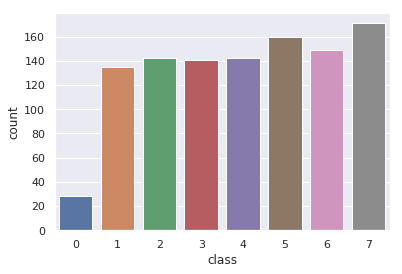

In [6]:
sns.countplot(df_train['class'])

In [12]:
# see how the imgs look
import random

# Kaggle
random_imgs = random.sample(list(os.listdir(RAW_IMG_DATA_PATH + '/raw')), 10)

# Non Kaggle
# random_imgs = random.sample(list(os.listdir(IMG_DATA_PATH)), 10)
print(random_imgs)

['3-17.jpg', '7-108.jpg', '7-8.jpg', '7-57.jpg', '5-115.jpg', '2-66.jpg', '1-28.jpg', '1-63.jpg', '3-33.jpg', '2-65.jpg']


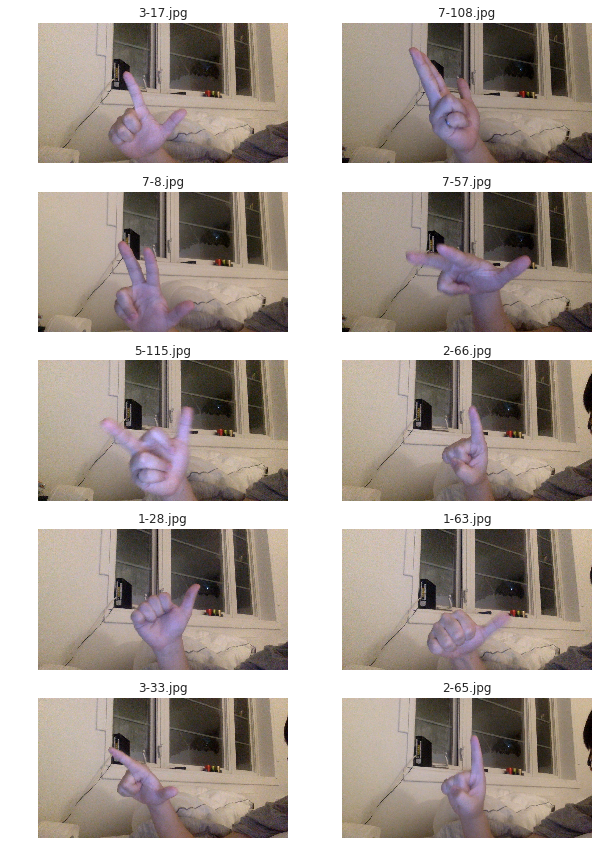

In [13]:
# looking at the imgs
from PIL import Image, ImageDraw

plt.figure(figsize=(10, 15))

for index, filename in enumerate(random_imgs):
    # Kaggle
    img = Image.open(RAW_IMG_DATA_PATH + '/raw/' + filename)

    # Non Kaggle
    # img = Image.open(IMG_DATA_PATH + '/raw/' + filename)

    plt.subplot(5,2,index+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)


## Modeling CNN

In [14]:
from sklearn.model_selection import train_test_split

df_train['class'] = df_train['class'].astype('str')

# dropping class 0 (class 0 was just for testing)
index_to_drop = df_train[df_train['class'].apply(lambda x: x == '0')].index
df_train = df_train.drop(index_to_drop)
df_train.head()

,filename,class
5,1-0.jpg,1
6,1-1.jpg,1
7,1-2.jpg,1
8,1-3.jpg,1
9,1-4.jpg,1


In [15]:
index_list = np.arange(df_train.shape[0])
print(index_list)

[   0    1    2 ... 1037 1038 1039]


In [16]:
df_train['class'].value_counts()

7    171
5    160
6    149
4    142
2    142
3    141
1    135
Name: class, dtype: int64

In [17]:
class_labels = list(df_train['class'])
# print(class_labels)

In [18]:
# applying stratification to have balanced separation between training / validation sets
train_idx, val_idx = train_test_split(
    index_list,
    stratify=class_labels,
    train_size=0.8,
    random_state=42
)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)

(832, 2)
(208, 2)


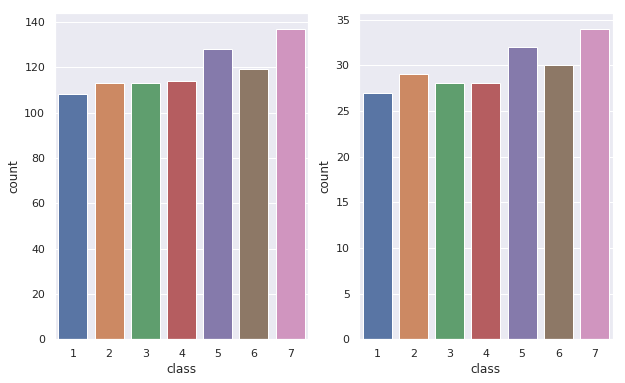

In [19]:
# check to see if stratification was successful

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.countplot(X_train['class'])
plt.subplot(1,2,2)
sns.countplot(X_val['class'])

In [20]:
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [21]:
img_size = (299, 299)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 20
batch_size = 32

# define image generator configs for train and validation
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.20,
    rotation_range = 30
)

val_datagen = ImageDataGenerator()

# create image data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train, 
    directory = RAW_IMG_DATA_PATH + '/raw/',
    # directory = IMG_DATA_PATH,
    x_col = 'filename',
    y_col = 'class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size = batch_size,
    seed = 42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory = RAW_IMG_DATA_PATH + '/raw/',
    # directory = IMG_DATA_PATH,
    x_col = 'filename',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=True
)

Found 832 validated image filenames belonging to 7 classes.
Found 208 validated image filenames belonging to 7 classes.


In [26]:
from keras import regularizers

# using xception model architecture to begin
xception_model = Xception(include_top=False, weights=None, input_tensor=None, input_shape=(299,299,3))

from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, ActivityRegularization

model = Sequential()
model.add(xception_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
_________________________________________________________________


In [30]:
from keras import optimizers

# optimizer = optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.00000001)
# optimizer = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [ ]:
# training the model

import gc
    
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

filepath = "model_{val_acc:.2f}_{val_loss:.4f}.h5"

ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=8, verbose=1, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=3,
                             verbose=0,
                             mode='auto',
                             min_delta=0.000001,
                             cooldown=0,
                             min_lr=0)

callbackList = [ckpt, es, reduceLR]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)

gc.collect()

Epoch 1/20
26/26 [==============================] - 46s 2s/step - loss: 2.5302 - acc: 0.2163 - val_loss: 7.4309 - val_acc: 0.0865

Epoch 00001: val_acc improved from -inf to 0.08654, saving model to model_0.09_7.4309.h5
Epoch 2/20
26/26 [==============================] - 31s 1s/step - loss: 1.9091 - acc: 0.3245 - val_loss: 12.2475 - val_acc: 0.1827

Epoch 00002: val_acc improved from 0.08654 to 0.18269, saving model to model_0.18_12.2475.h5
Epoch 3/20
26/26 [==============================] - 35s 1s/step - loss: 1.5605 - acc: 0.4038 - val_loss: 10.3083 - val_acc: 0.1442

Epoch 00003: val_acc did not improve from 0.18269
Epoch 4/20
26/26 [==============================] - 35s 1s/step - loss: 1.4142 - acc: 0.4459 - val_loss: 1.7160 - val_acc: 0.2260

Epoch 00004: val_acc improved from 0.18269 to 0.22596, saving model to model_0.23_1.7160.h5
Epoch 5/20
24/26 [==========================>...] - ETA: 2s - loss: 1.2844 - acc: 0.5078